# Alpha Spectrum Fitting & Automatic Isotope Range Derivation

This notebook demonstrates the new functional pipeline for:
1. Loading alpha spectra from energy_map binary files
2. Multi-peak Crystal Ball fitting **in instrumental (SCA) scale**
3. **Energy calibration** using literature values (E_true = a * E_SCA + b)
4. Automatic derivation of isotope ranges in calibrated energy (Option C: Windowed)
5. Integration with existing multiiso workflows

## Key Insight: Two-Stage Calibration
The raw data is in **SCA scale** (oscilloscope voltage / 1.058), not true energy.
We fit peaks in SCA scale first, then derive linear energy calibration using literature values.

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from RaTag.core.datatypes import Run
from RaTag.workflows.run_construction import initialize_run
from RaTag.pipelines.isotope_preparation import prepare_isotope_separation

# Spectrum fitting module (data and computation)
from RaTag.alphas.spectrum_fitting import (
    load_spectrum_from_run,
    fit_multi_crystalball_progressive,
    ranges_to_dict,
    derive_energy_calibration, 
    fit_full_spectrum_hierarchical,
    derive_isotope_ranges,
    prepare_hierarchical_fit,  # NEW: Prepare hierarchical fitting parameters
)

# Spectrum plotting module (visualization)
from RaTag.alphas.spectrum_plotting import (
    plot_preliminary_fits,
    plot_energy_calibration,
    plot_isotope_ranges,
    plot_hierarchical_fit,
    plot_calibration_summary,
)

## Step 1: Initialize Run and Generate Energy Maps

If energy maps don't exist yet, run this section. Otherwise skip to Step 2.

In [3]:
# Define run
path_multi = Path('/Volumes/KINGSTON/RaTag_data/RUN18')

run = Run(
    run_id="RUN18",
    root_directory=path_multi,
    target_isotope="Multi",
    pressure=2.0,
    temperature=297.0,
    sampling_rate=5.0,
    drift_gap=1.4,
    el_gap=0.8,
    el_field=2375.0,
    sets=[]
)

# Initialize (populates sets, computes fields)
run = initialize_run(run)


RUN INITIALIZATION

[1/3] Gas density...
  ✓ Gas density: 4.877e+19 cm⁻³

[2/3] Populating sets...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0050_Anode1950 - 3800 files (182400 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0100_Anode2000 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0200_Anode2100 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0300_Anode2200 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0400_Anode2300 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0500_Anode2400 - 4001 files (192048 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
  Loaded: FieldScan_Gate0600_Anode2500 - 4000 files (192000 waveforms) [Fast

In [4]:
# Generate energy maps if not already present
# This creates energy_maps/*.bin files from raw waveforms
run = prepare_isotope_separation(
    run,
    files_per_chunk=10,
    savgol_window=501,
    nbins=120,
    energy_range=(4, 9)  # MeV - avoid low-energy distortion
)


ISOTOPE PREPARATION: RUN18

ENERGY MAPPING GENERATION
Format: 8b, Files per chunk: 10
Pattern: *Ch4.wfm

Set 1/12: FieldScan_Gate0050_Anode1950
  📂 Energy maps already exist (skipping)

Set 2/12: FieldScan_Gate0100_Anode2000
  📂 Energy maps already exist (skipping)

Set 3/12: FieldScan_Gate0200_Anode2100
  📂 Energy maps already exist (skipping)

Set 4/12: FieldScan_Gate0300_Anode2200
  📂 Energy maps already exist (skipping)

Set 5/12: FieldScan_Gate0400_Anode2300
  📂 Energy maps already exist (skipping)

Set 6/12: FieldScan_Gate0500_Anode2400
  📂 Energy maps already exist (skipping)

Set 7/12: FieldScan_Gate0600_Anode2500
  📂 Energy maps already exist (skipping)

Set 8/12: FieldScan_Gate0700_Anode2600
  📂 Energy maps already exist (skipping)

Set 9/12: FieldScan_Gate0800_Anode2700
  📂 Energy maps already exist (skipping)

Set 10/12: FieldScan_Gate0900_Anode2800
  📂 Energy maps already exist (skipping)

Set 11/12: FieldScan_Gate1000_Anode2900
  📂 Energy maps already exist (skipping)

S

## Step 2: Load Spectrum from Energy Maps

The new functional approach loads data without mutating state.

In [5]:
# Load aggregated spectrum from all sets
spectrum = load_spectrum_from_run(
    run,
    energy_range=(4, 8.2),  # MeV - ROI for fitting
    aggregate=True  # Combine all sets for better statistics
)

print(f"Loaded {len(spectrum.energies):,} alpha events")
print(f"Energy range: {spectrum.energy_range[0]:.0f} - {spectrum.energy_range[1]:.0f} keV")
print(f"Source: {spectrum.source}")

Loaded 2,036,160 alpha events
Energy range: 4 - 8 keV
Source: RUN18_aggregated


## Step 3: Preliminary fitting: only main peaks

In [7]:
spectrum_full = load_spectrum_from_run(run, energy_range=(4, 8.2), aggregate=True)
energies, counts = spectrum_full.select_roi()

# Main peaks for preliminary fitting (5 peaks in SCA scale)
peak_definitions = [
    {'name': 'Th228', 'position': 4.5, 'window': (4.0, 4.7), 'sigma_init': 0.15, 'ref_energy': 5.42315},
    {'name': 'Ra224', 'position': 4.8, 'window': (4.65, 5.1), 'sigma_init': 0.15, 'ref_energy': 5.68537},
    {'name': 'Rn220', 'position': 5.4, 'window': (5.0, 5.5), 'sigma_init': 0.15, 'ref_energy': 6.40484},
    {'name': 'Po216', 'position': 5.9, 'window': (5.6, 6.1), 'sigma_init': 0.15, 'ref_energy': 6.90628},
    {'name': 'Po212', 'position': 7.5, 'window': (6.3, 8.0), 'sigma_init': 0.15, 'ref_energy': 8.785},
]

# Satellite peaks (for hierarchical fitting only)
satellite_definitions = [
    {'name': 'Th228_sat', 'ref_energy': 5.34036, 'branching_ratio': 0.385},
    {'name': 'Ra224_sat', 'ref_energy': 5.44860, 'branching_ratio': 0.054},
    {'name': 'Bi212', 'ref_energy': 6.207},  # Independent main peak
    {'name': 'Bi212_sat', 'ref_energy': 6.090, 'branching_ratio': 0.389},
]

fit_results = fit_multi_crystalball_progressive(energies, counts, peak_definitions=peak_definitions, global_beta_m=True)

  ✓ Th228: x0=4.5726 MeV, σ=0.1089 MeV
  ✓ Ra224: x0=4.7539 MeV, σ=0.1343 MeV
  ✓ Rn220: x0=5.3055 MeV, σ=0.0836 MeV
  ✓ Po216: x0=5.7336 MeV, σ=0.0835 MeV
  ✓ Po212 (α+β): x0=7.5160 MeV, σ=0.1355 MeV

  Average tail params: β=-2.152, m=3.071


/Users/pabloherrero/sabat/RaTagging/RaTag/alphas/spectrum_fitting.py:325: RuntimeWarning: invalid value encountered in power
  tail = A_tail / (B - z)**m


## Step 3.2: Visualize Fit Quality


✓ Visualization complete: 5 peaks fitted


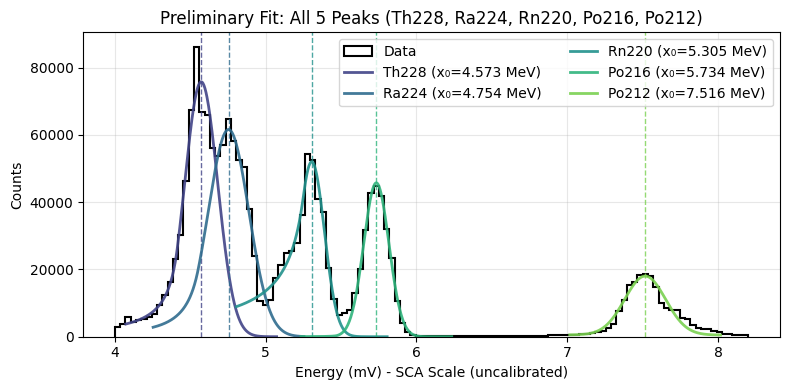

In [ ]:
peak_names = ['Th228', 'Ra224', 'Rn220', 'Po216', 'Po212']
fig, ax = plot_preliminary_fits(spectrum, fit_results, peak_names, figsize=(8, 4))
plt.show()

print(f"\n✓ Visualization complete: {len(fit_results)} peaks fitted")

## Step 4: Derive Energy Calibration (Linear and Quadratic)

All fits were performed in **SCA scale** (instrumental units in **mV**). Now derive the calibration:

Linear: **E_true [MeV] = a × E_SCA [mV] + b**
- Simple 2-parameter fit
- Works well for narrow energy range

Quadratic: **E_true [MeV] = a × E_SCA² [mV²] + b × E_SCA [mV] + c**
- 3-parameter fit, handles detector non-linearity
- **Recommended when including Po-212** (high-energy anchor at 8.785 MeV)
- Better handles curvature across 4-9 MeV range

Using 5 anchor points:
- **Th-228**: 5.423 MeV
- **Ra-224**: 5.686 MeV  
- **Rn-220**: 6.405 MeV
- **Po-216**: 6.906 MeV
- **Po-212**: 8.785 MeV ← High-energy anchor (critical for curvature)

In [9]:
# Build literature energies from peak definitions
literature_energies = {p['name']: p['ref_energy'] for p in peak_definitions}

calibration_linear = derive_energy_calibration(fit_results, literature_energies,
                                               use_peaks=list(literature_energies.keys()), order=1)

calibration_quad = derive_energy_calibration(fit_results, literature_energies,
                                             use_peaks=list(literature_energies.keys()), order=2)

print("="*70)
print("ENERGY CALIBRATION")
print("="*70)
print(f"\nLinear RMS residual:    {np.sqrt(np.mean(calibration_linear.residuals**2)):.4f} MeV")
print(f"Quadratic RMS residual: {np.sqrt(np.mean(calibration_quad.residuals**2)):.4f} MeV")
print(f"Improvement:            {(1 - np.sqrt(np.mean(calibration_quad.residuals**2))/np.sqrt(np.mean(calibration_linear.residuals**2))) * 100:.1f}%")

ENERGY CALIBRATION

Linear RMS residual:    0.0671 MeV
Quadratic RMS residual: 0.0086 MeV
Improvement:            87.2%



✓ Quadratic calibration reduces residuals, especially for Po-212


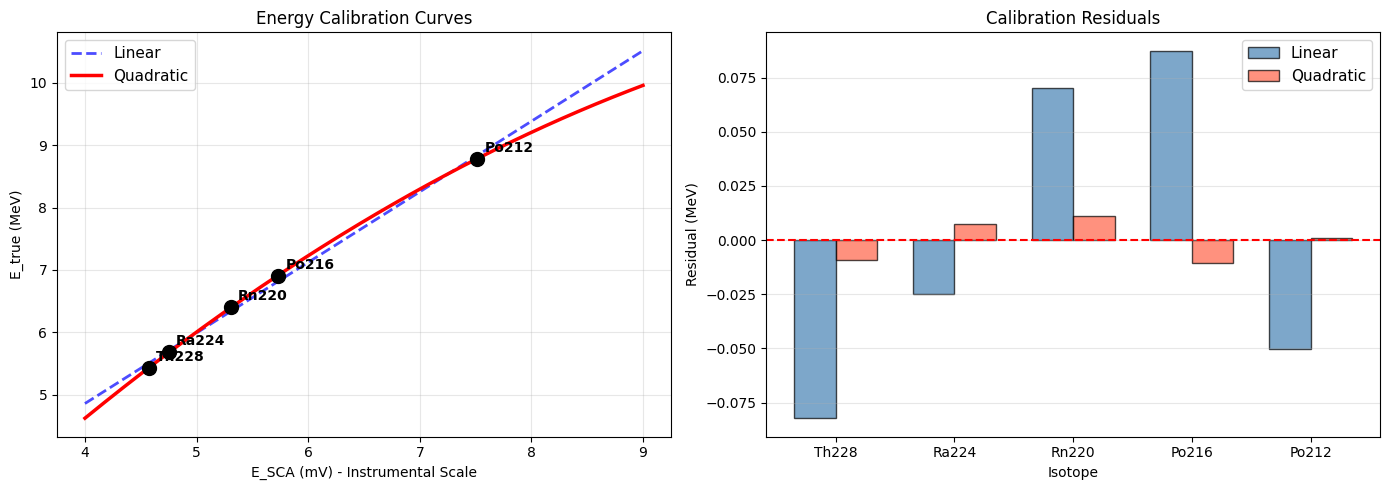

In [ ]:
fig, (ax1, ax2) = plot_energy_calibration(calibration_linear, calibration_quad, figsize=(14, 5))
plt.show()

print("\n✓ Quadratic calibration reduces residuals, especially for Po-212")

In [21]:
calibration = calibration_quad
energies_calibrated = calibration.apply(spectrum.energies)
spectrum_calibrated_full = calibration.apply(spectrum.energies)

print(f"Calibrated range: {energies_calibrated.min():.3f} - {energies_calibrated.max():.3f} MeV")

Calibrated range: -1.961 - 11.377 MeV


## Step 5: Derive Isotope Ranges (Option C: Windowed) and Visualize

Automatically find "pure" regions where one isotope dominates.

In [13]:
# Derive ranges from individual fits in CALIBRATED energy scale
n_sigma = 1  # Standard deviation multiplier

isotope_ranges = derive_isotope_ranges(fit_results=fit_results, calibration=calibration,
                                       literature_energies=literature_energies, n_sigma=n_sigma)

print("\nDerived Isotope Ranges (CALIBRATED ENERGIES):")
print("="*70)

for name, range_obj in isotope_ranges.items():
    E_lit = literature_energies.get(name, 0.0)
    print(f"{name:8s}: [{range_obj.E_min:.3f}, {range_obj.E_max:.3f}] MeV, "
          f"peak={range_obj.E_peak:.3f} MeV (lit: {E_lit:.3f} MeV, "
          f"Δ={abs(range_obj.E_peak-E_lit)*1000:.1f} keV)")

print("="*70)
print(f"\n✓ Derived ranges for {len(isotope_ranges)} isotopes (including Po212)")



Derived Isotope Ranges (CALIBRATED ENERGIES):
Th228   : [5.283, 5.581] MeV, peak=5.432 MeV (lit: 5.423 MeV, Δ=9.0 keV)
Ra224   : [5.498, 5.858] MeV, peak=5.678 MeV (lit: 5.685 MeV, Δ=7.5 keV)
Rn220   : [6.289, 6.499] MeV, peak=6.394 MeV (lit: 6.405 MeV, Δ=11.0 keV)
Po216   : [6.818, 7.016] MeV, peak=6.917 MeV (lit: 6.906 MeV, Δ=10.4 keV)
Po212   : [8.661, 8.907] MeV, peak=8.784 MeV (lit: 8.785 MeV, Δ=0.9 keV)

✓ Derived ranges for 5 isotopes (including Po212)


### Step 5.2 Visualize Purity Across Energy Range

Show where each isotope dominates (Option B visualization).

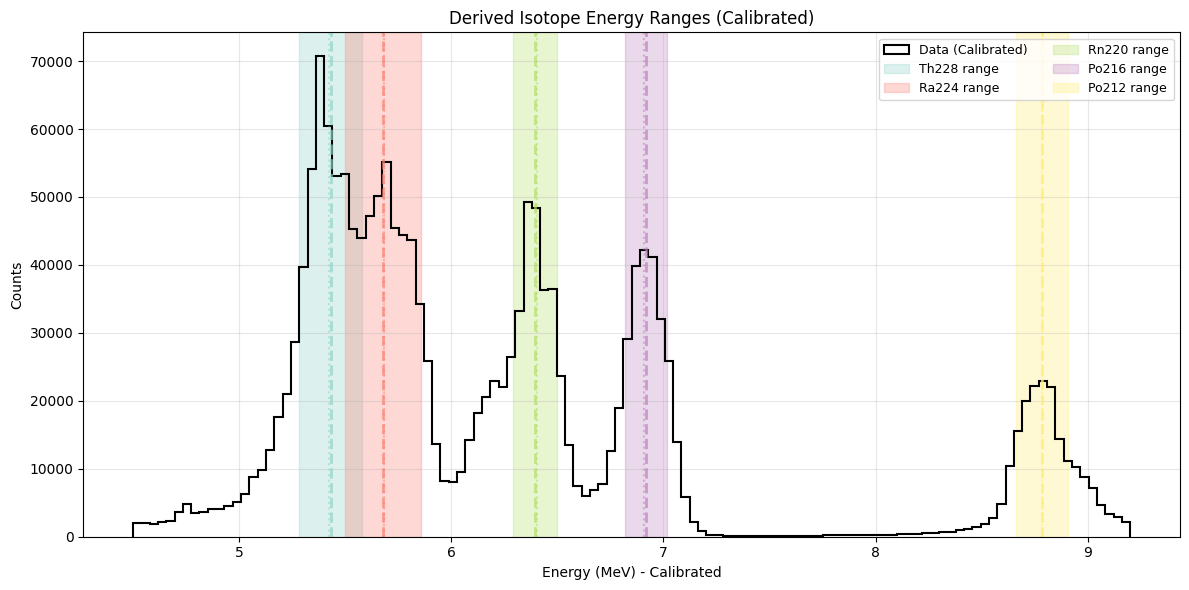

In [ ]:
fig, ax = plot_isotope_ranges(spectrum_calibrated_full, isotope_ranges, figsize=(12, 6))
plt.show()

### Step 5.3: Workshop Composite Figure (4-Panel Summary)

Combine everything into a single comprehensive figure for presentations.

/Users/pabloherrero/sabat/RaTagging/RaTag/alphas/spectrum_fitting.py:265: RuntimeWarning: invalid value encountered in power
  def plot_residuals(ax, x, data, model, show_poisson=True):


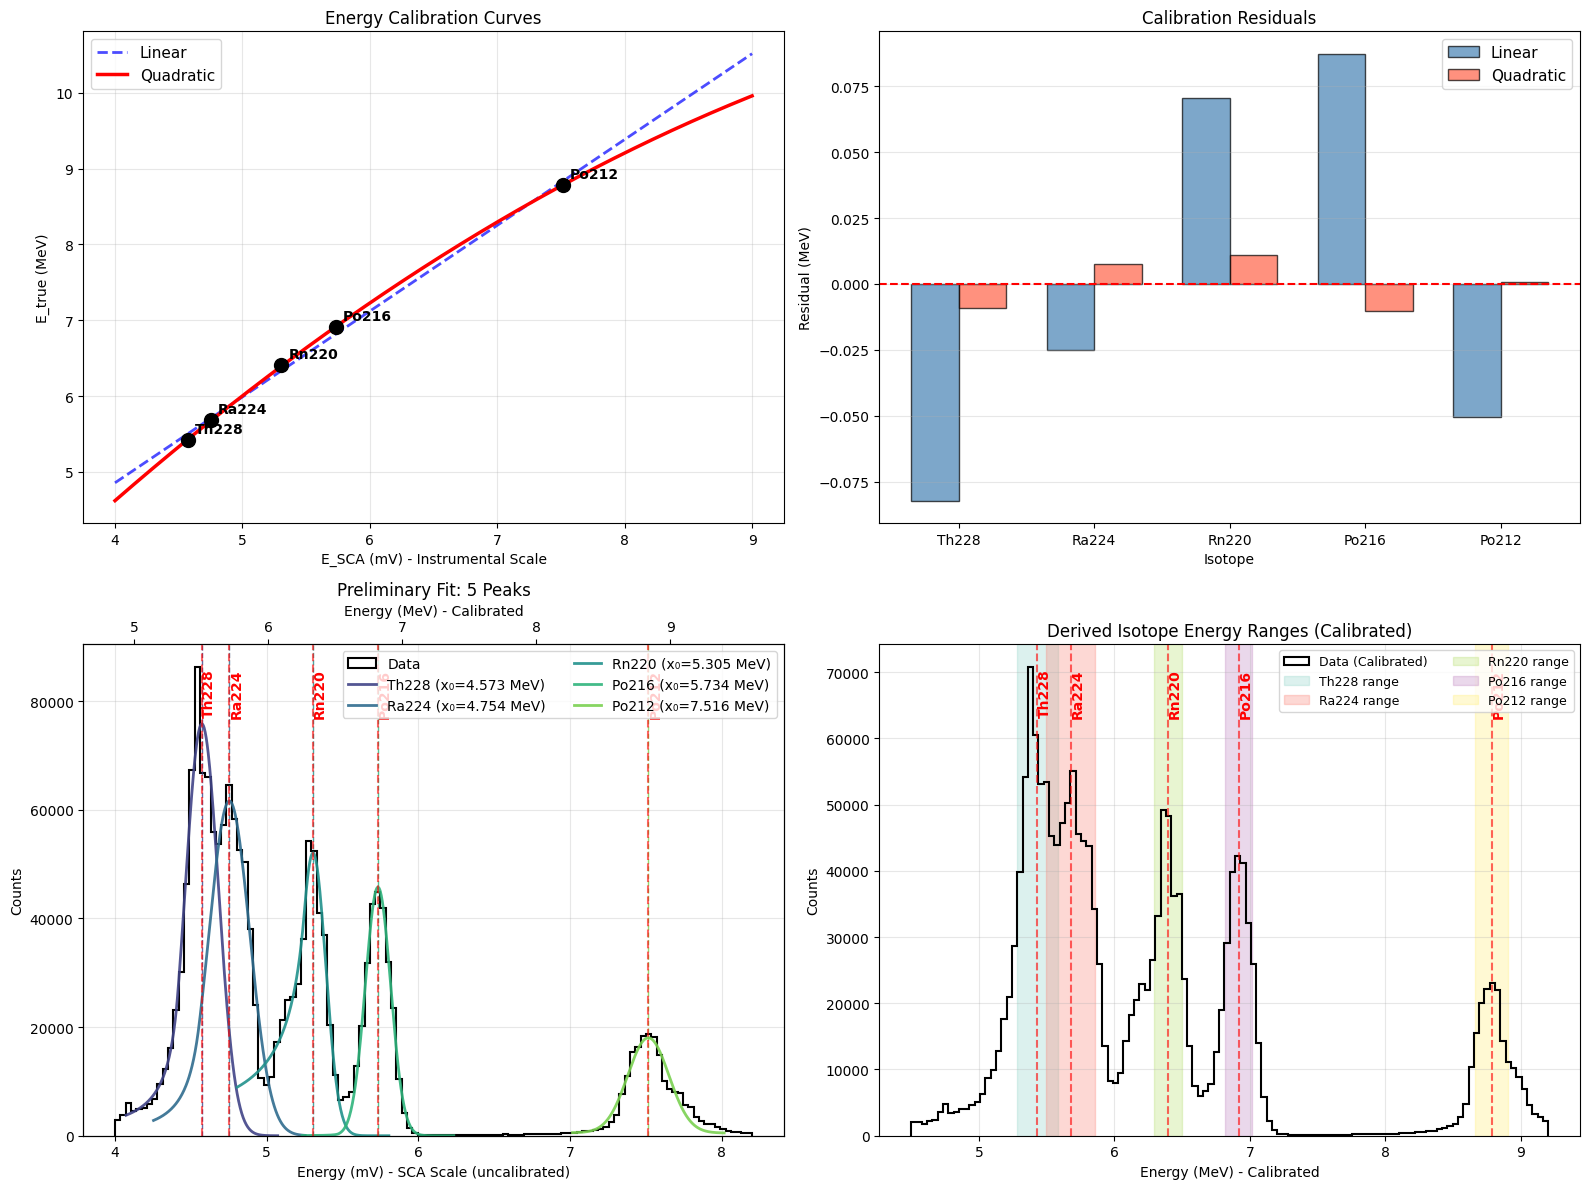


✓ Comprehensive 4-panel summary figure generated!


In [29]:
peak_names = ['Th228', 'Ra224', 'Rn220', 'Po216', 'Po212']

fig, axes = plot_calibration_summary(spectrum=spectrum_full, fit_results=fit_results,
                                      peak_names=peak_names, 
                                      calibration_linear=calibration_linear, 
                                      calibration_quad=calibration_quad,
                                      spectrum_calibrated=spectrum_calibrated_full, 
                                      isotope_ranges=isotope_ranges, figsize=(16, 12))
plt.show()

print("\n✓ Comprehensive 4-panel summary figure generated!")

## Step 7: Convert to Format for Existing Workflows

The derived ranges can be used directly with existing multiiso workflows.


In [15]:
# Convert to simple dict format for compatibility
ranges_dict = ranges_to_dict(isotope_ranges)

print("\nRanges for multiiso workflows:")
print("isotope_ranges = {")
for isotope, (E_min, E_max) in ranges_dict.items():
    print(f"    '{isotope}': [{E_min:.1f}, {E_max:.1f}],")
print("}")


Ranges for multiiso workflows:
isotope_ranges = {
    'Th228': [5.3, 5.6],
    'Ra224': [5.5, 5.9],
    'Rn220': [6.3, 6.5],
    'Po216': [6.8, 7.0],
    'Po212': [8.7, 8.9],
}


## Step 6: Hierarchical Fitting of Full Spectrum

**Goal**: Fit all 9 alpha peaks (including doublet satellites) with physics-based constraints.

**Strategy**: Use preliminary fits and energy calibration to constrain:
- **Fixed positions**: Literature values for all peaks
- **Fixed shapes**: σ, β, m transformed from SCA fits using calibration.derivative()
- **Amplitude constraints**: Satellites linked to mains via branching ratios
  - Example: `N_sat = N_main × (BR_sat/BR_main)`

**Result**: 9 peaks (Th228×2, Ra224×2, Bi212×2, Rn220, Po216, Po212) fitted with only 6 free parameters instead of 45.


### Hierarchical Fit Implementation

Fit full spectrum with **simplified interface**:
- **9 peaks**: Th228×2, Ra224×2, Bi212×2, Rn220, Po216, Po212
- **6 free parameters**: Main peak amplitudes (Th228, Ra224, Bi212) + singlets (Rn220, Po216, Po212)
- **3 constrained parameters**: Satellites linked to mains via branching ratios
- **All positions and shapes FIXED** from preliminary fits and energy calibration

Peak shapes are transformed from SCA to calibrated space using:
```python
sigma_calibrated = abs(calibration.derivative(E_SCA)) * sigma_SCA
```

Example satellite constraint: `N_sat = N_main × (BR_sat/BR_main)`


In [32]:
# Prepare hierarchical fitting parameters
calibrated_sigmas, beta_avg, m_avg, energies_calibrated, counts_calibrated = prepare_hierarchical_fit(
    fit_results=fit_results,
    calibration=calibration_linear,
    spectrum_calibrated=spectrum_calibrated_full,
    exclude_from_shape=['Po212']  # Po212 is an outlier for shape parameters
)

# Bi212 uses Rn220 shape parameters (since Bi212 wasn't in preliminary fits)
calibrated_sigmas['Bi212'] = calibrated_sigmas['Rn220']

print("\n✓ Hierarchical fit parameters prepared")
print(f"  Calibrated sigmas computed for {len(calibrated_sigmas)} peaks")
print(f"  Histogram binned: {len(energies_calibrated)} bins")


Average shape parameters (excluding ['Po212']):
  β_avg = -1.682
  m_avg = 1.339

✓ Hierarchical fit parameters prepared
  Calibrated sigmas computed for 6 peaks
  Histogram binned: 120 bins


In [33]:
result_hierarchical = fit_full_spectrum_hierarchical(energies_calibrated, counts_calibrated,    
                                                     peak_definitions=peak_definitions + satellite_definitions,
                                                     calibrated_sigmas=calibrated_sigmas,
                                                     beta_avg=beta_avg, m_avg=m_avg, 
                                                     normalize=True, x0_tolerance=0.04
)


  Hierarchical Fit:
    Total peaks: 9
    Free parameters: 12
    Constrained parameters: 3
    χ²_reduced: 0.001
    BIC: -735.9


/Users/pabloherrero/sabat/RaTagging/RaTag/alphas/spectrum_fitting.py:265: RuntimeWarning: invalid value encountered in power
  def plot_residuals(ax, x, data, model, show_poisson=True):


### Visualization: Hierarchical Fit with Deconvolved Components

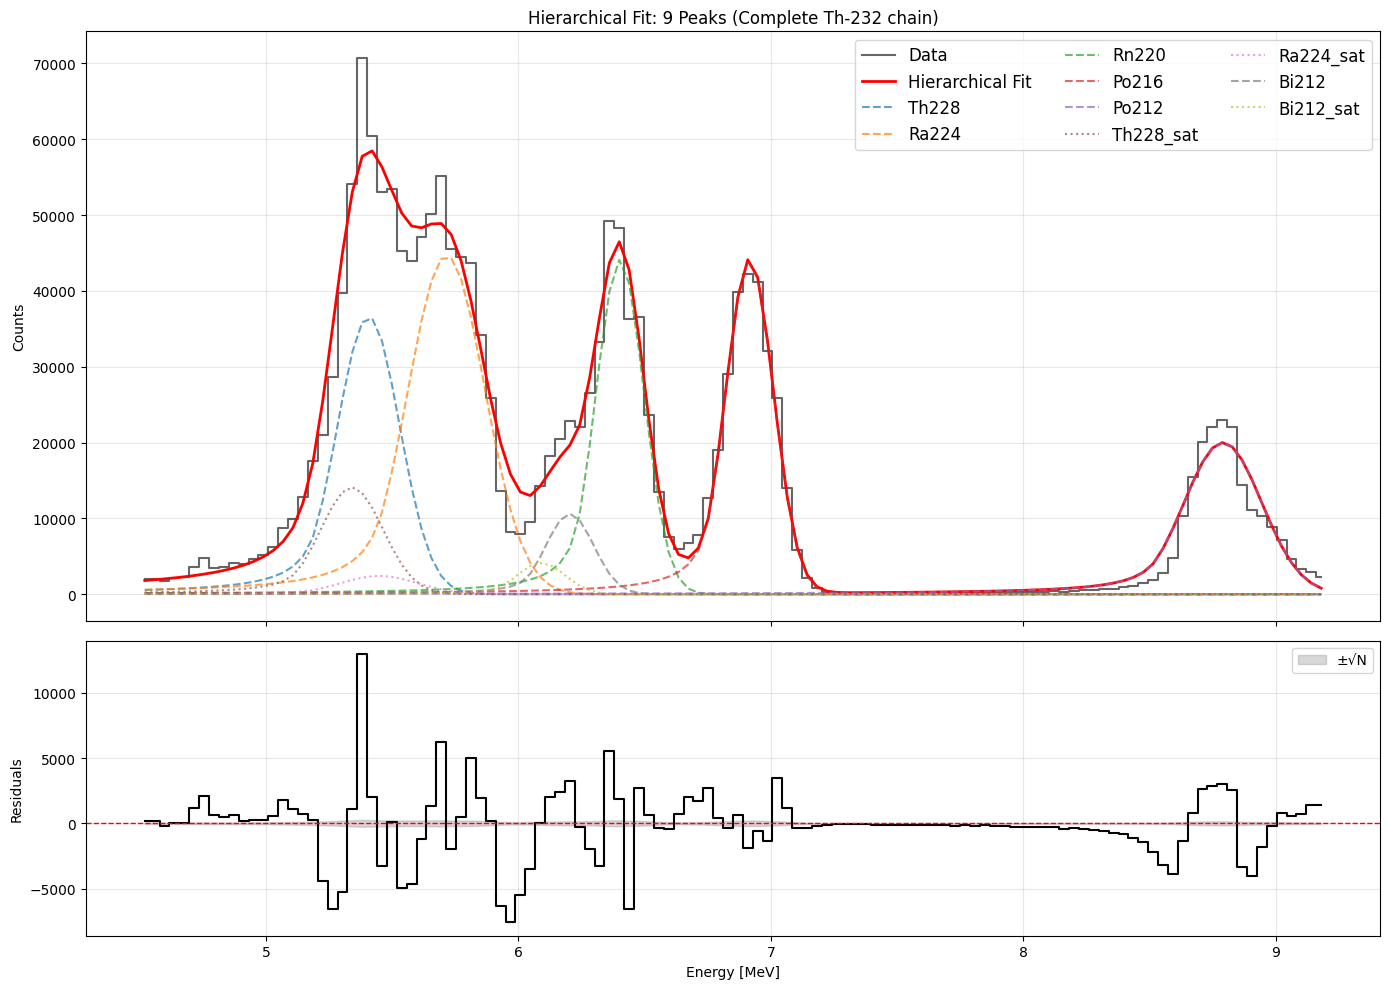

In [34]:
fig, (ax1, ax2) = plot_hierarchical_fit(energies_calibrated, counts_calibrated, result_hierarchical, 
                                        figsize=(14, 10), height_ratios=(2, 1))
plt.show()